# Naive Bayes

In [1]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import pickle
from src.train_test import *
from src.preprocessor import *
from src.assess import *

In [2]:
# Read, split, and transform the data

data = pd.read_csv('smog_data_cleaned.csv')
X_train, X_test, y_train, y_test = split(data)
preprocessor = preprocesser()
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
X_train_df = pd.DataFrame(X_train_transformed.toarray())
X_test_df = pd.DataFrame(X_test_transformed.toarray())

In [3]:
GNB = GaussianNB()
GNB.fit(X_train_transformed.toarray(),y_train)

GaussianNB()

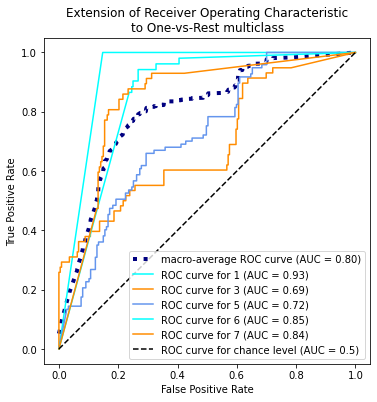

In [4]:
cv_gnb = cv_predict_interval(GNB, X_train_transformed.toarray(), y_train)
mean_cv_gnb = get_mean_cv(cv_gnb)
results_gnb = mean_std_cross_val_scores(GNB, X_train_transformed.toarray(), y_train,return_train_score=True,scoring='accuracy')
misClassificationRate_GNB = calc_misclass_rate_pred_interval(GNB.predict_proba(X_test_transformed.toarray()),y_test)
test_score_gnb = GNB.score(X_test_transformed.toarray(), y_test)
auc_gnb = auc_drawer(GNB, X_test_transformed.toarray(), y_train, y_test)
auc_gnb = list(auc_gnb.values())
roc_gnb = roc_auc_score(y_test, GNB.predict_proba(X_test_transformed.toarray()), multi_class='ovr', average = 'weighted')

cm_gnb = confusion_matrix(y_test, GNB.predict(X_test_transformed.toarray()))
cm_gnb = cm_gnb.diagonal()/cm_gnb.sum(axis=1)
cm_gnb = cm_gnb.tolist()

In [5]:
cv_tb = cv_result_table(cv_gnb, mean_cv_gnb, results_gnb['test_score'],results_gnb['train_score'])
test_tb = get_test_result_table(misClassificationRate_GNB, cm_gnb, test_score_gnb, auc_gnb, roc_gnb).round(4)

print(cv_tb)
print(test_tb)

                    1      2      3      4      5               mean
pred50          0.549  0.556  0.523  0.508  0.538              0.535
pred80          0.549  0.534  0.508    0.5  0.538              0.526
Train_Accuracy      -      -      -      -      -  0.503 (+/- 0.017)
Test_Accuracy       -      -      -      -      -  0.465 (+/- 0.020)
                  1      3      5      6      7  Overall
class_pred50  0.000  0.776  0.856  0.058  0.386    0.415
class_pred80  0.000  0.759  0.856  0.058  0.386    0.412
Accuracy      1.000  0.224  0.144  0.942  0.614    0.461
AUC           0.926  0.687  0.717  0.850  0.841    0.775


In [6]:
## Applying PCA

In [7]:
GNB_pca = GaussianNB()
# Concatenate the training and test data
X_all = np.concatenate((X_train_transformed.toarray(), X_test_transformed.toarray()), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)

# Apply PCA
trans_pca = PCA(n_components=0.7)
X_all_pca = trans_pca.fit_transform(X_all)

# Split the data back into training and test sets
X_train_pca = X_all_pca[:len(y_train)]
X_test_pca = X_all_pca[len(y_train):]

# Fit model
GNB_pca.fit(X_train_pca,y_train)

GaussianNB()

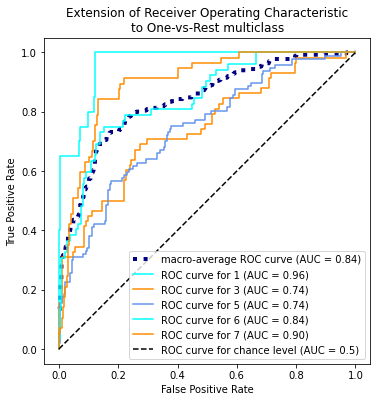

In [8]:
# Fit model

cv_gnb_pca = cv_predict_interval(GNB_pca, X_train_pca, y_train)
mean_cv_gnb_pca = get_mean_cv(cv_gnb_pca)
results_gnb_pca = mean_std_cross_val_scores(GNB_pca, X_train_pca, y_train,return_train_score=True,scoring='accuracy')
misClassificationRate_GNB_pca = calc_misclass_rate_pred_interval(GNB_pca.predict_proba(X_test_pca),y_test)
test_score_gnb_pca = GNB_pca.score(X_test_pca, y_test)
auc_gnb_pca = auc_drawer(GNB_pca, X_test_pca, y_train, y_test)
auc_gnb_pca = list(auc_gnb_pca.values())
roc_gnb_pca = roc_auc_score(y_test, GNB_pca.predict_proba(X_test_pca), multi_class='ovr')

cm_gnb_pca = confusion_matrix(y_test, GNB_pca.predict(X_test_pca))
cm_gnb_pca = cm_gnb_pca.diagonal()/cm_gnb_pca.sum(axis=1)
cm_gnb_pca = cm_gnb_pca.tolist()


In [9]:
cv_pca_tb = cv_result_table(cv_gnb_pca, mean_cv_gnb_pca, results_gnb_pca['test_score'],results_gnb_pca['train_score'])
test_pca_tb = get_test_result_table(misClassificationRate_GNB_pca, cm_gnb_pca, test_score_gnb_pca, auc_gnb_pca, roc_gnb_pca).round(4)

print(cv_pca_tb)
print(test_pca_tb)

                    1      2      3      4      5               mean
pred50          0.331  0.384   0.28  0.447  0.341              0.356
pred80           0.18   0.21  0.144  0.258  0.197              0.198
Train_Accuracy      -      -      -      -      -  0.579 (+/- 0.009)
Test_Accuracy       -      -      -      -      -  0.565 (+/- 0.045)
                  1      3      5      6      7  Overall
class_pred50  0.600  0.534  0.289  0.250  0.246    0.384
class_pred80  0.300  0.328  0.124  0.192  0.105    0.210
Accuracy      0.400  0.310  0.629  0.712  0.649    0.567
AUC           0.963  0.744  0.743  0.844  0.896    0.838


In [11]:
with open('workspace_file/03b_1_nb_cv.pkl', 'wb') as f:
    pickle.dump(cv_tb, f)
    
with open('workspace_file/03b_2_nb_test.pkl', 'wb') as f:
    pickle.dump(test_tb, f)
    
with open('workspace_file/03b_3_nb_pca_cv.pkl', 'wb') as f:
    pickle.dump(cv_pca_tb, f)
    
with open('workspace_file/03b_4_nb_pca_test.pkl', 'wb') as f:
    pickle.dump(test_pca_tb, f)  